# Building our MeV toy detector

## The dominant interaction

First, let's at the different way that the gamma ray can interact with out detector material:

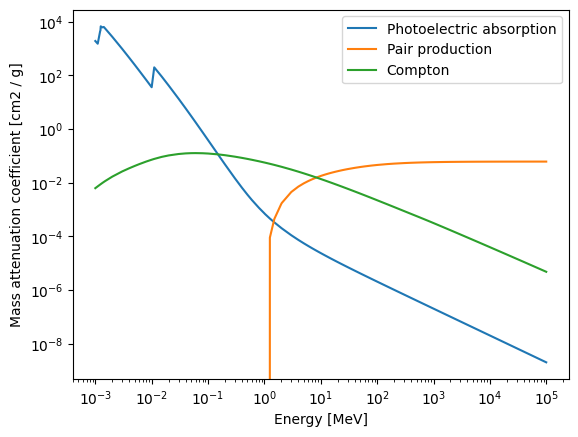

In [1]:
from gammaraytoys import Material

Ge = Material.from_name('Ge') # Only one available for now

Ge.plot_attenuation();

Although we're plotting the case for Germanium --you can see other material in the [NIST XCOM](https://www.nist.gov/pml/note-nist-x-ray-attenuation-databases) database--  most materials follow the same behavior: dominated by photoelectric (full) absorption a low energies, pair production at high energies, and a region in the middle where it is mostly Comtpon scattering. This is the MeV range, our energy range for the rest of the tutorials.

The probability a gamma ray will interact with the material is:

$$ P_{int} = 1 - \exp \left( - \alpha \rho \Delta x   \right) $$

where $\alpha$ is the mass attenuation coeficient, $\rho$ us the material density, and $\Delta x$ is the distance that the gamma ray needs to go through.

## Basics of Compton scattering

Since we'll be dominated by Compton events, it's worth checking the basics. When a gamma-ray scatters from an electron, at rest and unbound, there is a relation between the initial energy, the (polar) scattering angle, and the energy of the scattered gamma ray:

$$E_{\gamma}^\prime = \frac{E_\gamma}{1 + (E_\gamma/m_e c^2)(1-\cos\phi)}$$

where $m_e c^2 = 510.99 keV$, the electron mass. The key piece of information from this equation is that we can determined the scattering angle $\phi$ my measuring the ingoing and outgoing energy. That is, purely from kinematics, without the need to track the direction of the particles. This enables imaging, as we'll see later.

<div>
<img src="../figures/compton_scattering.png" width="300"/>
</div>

The distribution of the scattering angle is determined by the [Klein-Nishina_formula](https://en.wikipedia.org/wiki/Klein%E2%80%93Nishina_formula):

$$\frac{d\sigma}{d\Omega} \propto \left(\frac{E'}{E}\right)^{2} \left[\frac{E'}{E} + \frac{E}{E'} - \sin^2 \phi\right]$$

where $d\sigma/d\Omega$ is the differential cross section pero solid angle area. The total effective area is normalized to based on the attenuation coefficient. 

Combined with the Compton kinematic equation, the distritbution look like this for various energies:

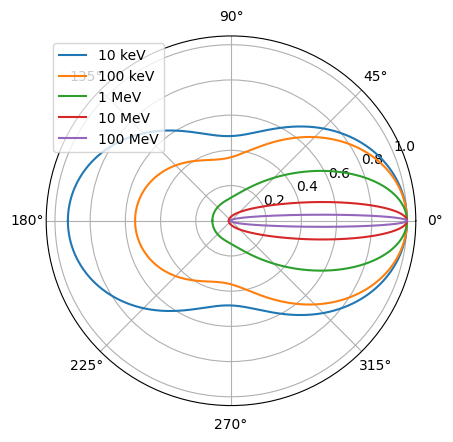

In [2]:
from gammaraytoys.physics import ComptonPhysics2D
from astropy import units as u

ax = None
for energy in [10*u.keV, 100*u.keV, 1*u.MeV, 10*u.MeV, 100*u.MeV]:
    ax = ComptonPhysics2D(energy).plot_scattering_angle_pdf(ax, label = f"{energy:.0f}")

ax.legend()

There are two take-home-messages:
1. The Compton scattering angle can be anything! It's not uncommon the even have backscattering
2. As we go higher in energy, most events tend to forwards scatter, but the distribution of scattering angle is still pretty broad

You might have seen the "2D" in "ComptonPhysics2D". For this tutorial we will limit ourselves to the a 2D world, where everything is easier to visualize. The physics of this world are mostly the same as our, however, $d\sigma/d\Omega$ simplifies to $d\sigma/d\phi$. That is, we don't have to take the phase space of the azimuthal scattering angle into account. 

And talking about the azimuthal scattering angle --let's call it $\zeta$-- in our 3D world it happens to be modulated by the polarization of the incoming photon:

$$\frac{d\sigma}{d\Omega} \propto \left(\frac{E'}{E}\right)^{2} \left[\frac{E'}{E} + \frac{E}{E'} - 2\sin^2 \phi \cos^2(\mathrm{PA} - \zeta- \pi/2)\right]$$

with the maximum perpendicular to the direction of the photon electric field --i.e. the polarization angle ($\mathrm{PA}$). You can obtain the unpolarized version by averaging over $\zeta$ --$\frac{1}{2\pi}\int_0^{2\pi} \cos^2\zeta d\zeta = \frac{1}{2}$

While it's impossible for our 2D world to fully represent this effect, in the physics of this flat world photons still have "chirality" --$k\in[-1,1]$--- that is, a preference to go either left --$\zeta_{2D} = 1$-- or right --$\zeta_{2D} = -1$-- of the inital direction is:

$$\frac{d\sigma}{d\phi} \propto \left(\frac{E'}{E}\right)^{2} \left[\frac{E'}{E} + \frac{E}{E'} - 2\sin^2 \phi H(k \zeta_{2D})\right]$$

where $H(x)$ is the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) --$H(x<0) = 0, H(x>0) = 1$

Whether it's the real 3D world or flatland, the ratio between the $\zeta$-dependent and non-$\zeta$-dependent part of the differential cross section is called the modulation factor:

$$\mu = \frac{2\sin \phi}{\frac{E'}{E} + \frac{E}{E'}}$$

Combined with the Compton kinematic equation, the distritbution look like this for various energies:

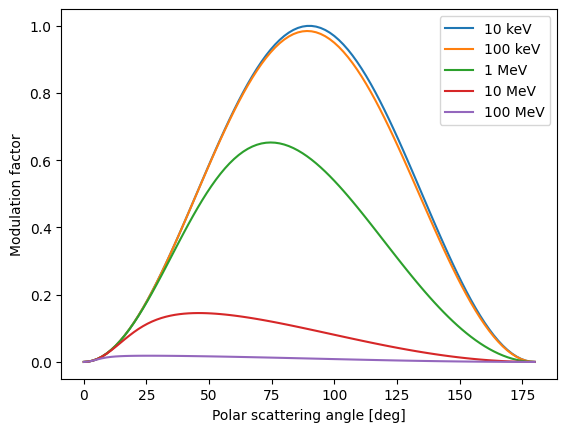

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
for energy in [10*u.keV, 100*u.keV, 1*u.MeV, 10*u.MeV, 100*u.MeV]:
    ComptonPhysics2D(energy).plot_modulation_factor(ax, label = f"{energy:.0f}")

ax.legend()

Also two take-home messages main from this plot:
- It's easier to measure polarization --or "chirality" in flatland-- at relative low energies
- Most of the fitting or discrimination leverage comes from scaterring angles around $\phi = 90^{\circ}$. If you have a detector that can only measured forward-scattered events you'll have a hard time measuring polarization.

## Detector designing

Here and through all the tutorials will use a multi-layer detector made out of Germanium. You can choose the total length of each layer, the number of layers and their locations (y-axis) of each layer, as well as their thickness. This is you detector mass model, very similar to what we do in MEGAlib's [Geomega](https://raw.githubusercontent.com/zoglauer/megalib/main/doc/Geomega.pdf). In addition, you can specify the detector's energy resolution, defined as the ratio $\Delta E/E$ of the measured energy and the deposited energy on each interaction, and the energy threshold, the minimum detectable deposited energy.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

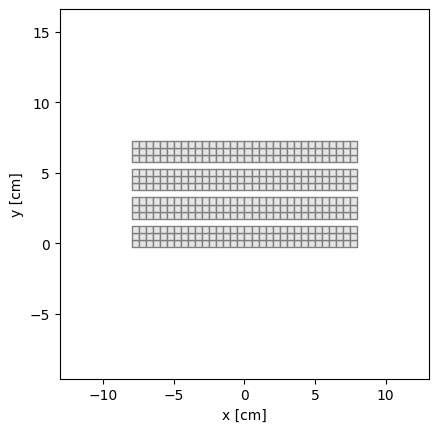

In [4]:
from gammaraytoys import ToyTracker2D
import numpy as np

det = ToyTracker2D(material = 'Ge',
                   layer_length = 16*u.cm, 
                   layer_positions = [0,5,10, 20,25,30, 40,45,50, 60,65,70]*u.mm, 
                   layer_thickness = 5*u.mm, 
                   energy_resolution = 0.01,
                   energy_threshold = 20*u.keV)

det.plot()

This detector is somewhat COSI-like. It has the similar dimensions, the same total amount of Germanium, as well a position resolution, energy resolution and energy threshold of the same order.

As opposed to COSI though, you might have noticed that our detector is composed of individual pixels, about the same size of the layer thickness which sets the position resolution of our detector. While we'll simulate the physics of all Compton interactions, as described in the previous section, the simulations were simplified by assuming that the layers are thin enough that we only need to worry about a single interact every time a photon reaches a layer. 

This assummes that:
1. The layer thickness is smaller than the photon's mean free path $l_{\mathrm{free}}^{\gamma} = (\alpha \rho)^{-1}$. For Germanium $l_{\mathrm{free}}^{\gamma} = \{0.37,3.3,6.0\}\mathrm{cm}$ for energies {0.1,1,10} MeV, respectively.
2. The thickness/length ratio is small enough that the "near horizontal" interations within the layer are negligible.

In summary, don't go crazy on the layer thickness, or you are going to break it! Note that this doesn't stop you from simulating a thick detector, just use multiple thin layers on top of each other. Keep this in mind and you'll have great fun with this toy while still being more or less realistic. 

Let's simulate out first particle:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

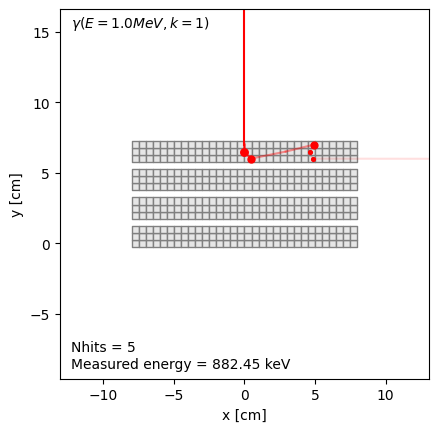

In [31]:
from gammaraytoys.detectors import Photon
from gammaraytoys.coordinates import Cartesian2D

primary = Photon(position = Cartesian2D(x = 0*u.cm, y = 18*u.cm),
                 direction = -90*u.deg,
                 energy = 1*u.MeV,
                 chirality = 1)

sim_event = det.simulate_event(primary)

det.plot(event = sim_event)

The red line correspond to the track of the primary and secondary gamma rays. The opacity is set proportional to the ratio of their energy and the energy of the primary. The circles correspond to the measured hits, with a size proportional to the deposited energy.

This is very similar to what happens inside MEGAlib's [Cosima](https://raw.githubusercontent.com/zoglauer/megalib/main/doc/Cosima.pdf) (which uses [GEANT4](https://geant4.cern.ch/) internally).

<div class="alert alert-block alert-info">
<b>Exercise: Play with the toy detector!</b>

- Try visualizing a bunch of events, get a feeling for the kind of thing that can happen.
    - Vary the gamma-ray injected position, direction, and energy. Try also playing with the chirality parameter, which is random by default.
    - Try different number of layers, layer separation, length and thinkness, as well as the effect of the energy resolution and threshold
- Scavanger hunt: find these kinds of events:
    - Fully contained in the detector
    - Only interacted once with the detector (single site events)
    - The photon interacted with a layer, but the hit wasn't detected (below threshold)
    - The event took a curve and went upwards, and interacting again with the first layer it had initially hit.
</div>

## The traditional Compton detector

Excersize draw_tracks = false

Our current detector is nice and cozy, no doubt, but it has a big complication. Since everything happens very fast (at the speed of light!) our detector doesn't have enough time resolution to tell us the order of the hits in time. For a separation of e.g. 1 cm, we would need a time resolution of 10 ps! 

As you've seen in the previous excersize, the tracks can go wild, even turning back sometimes. It's however crucial to know which ones were the first two hits in order to have any chance at contraining the direction of the incoming particle.

<div class="alert alert-block alert-info">
<b>Exercise: Reconstruction by eye</b>
The cell below simulates photon from random directions --i.e. an isotropic source). Simulate a some photon until you get at least 2 interaction. With the actual track hidden and only the knowledge of the hits, try to guess which ones were the first two hits. Then move to the following cell, unveil the track, and see if you guess was true. Repeat this multiple time and access your success ratio
</div>

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

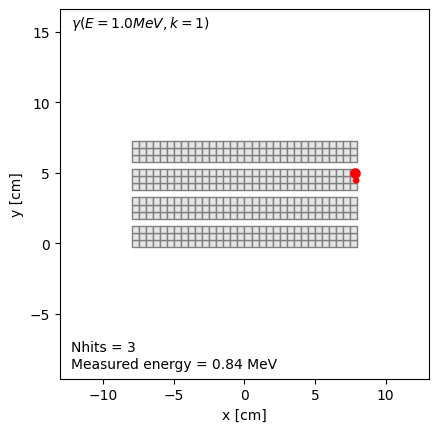

In [12]:
from gammaraytoys.detectors import IsotropicSource, MonoenergeticSpectrum

source = IsotropicSource(spectrum = MonoenergeticSpectrum(1*u.MeV))

primary = source.random_photon(det)

sim_event = det.simulate_event(primary)
det.plot(event = sim_event, draw_track = False)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

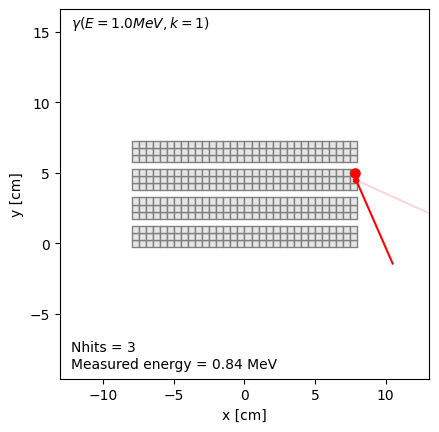

In [13]:
det.plot(event = sim_event, draw_track = True)

It's likely your success rate by eye is not very high. Mine is not, at least. Suprisingly, as demostrated by COSI, it is actually possible to get a high success rate using the knowledge of the kinematic and some computationally intensive algorithms. Maybe at some point I'll write a tutorial about it, but for now we'll intead something more similar to a traditional Compton telelescope:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

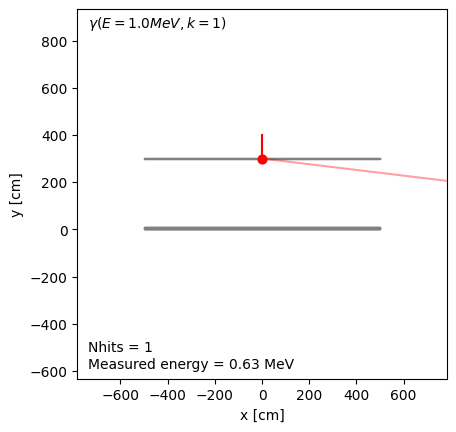

In [7]:
trad_det = ToyTracker2D(material = 'Ge',
                       layer_length = 10*u.m, 
                       layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                       layer_thickness = 1*u.cm, 
                       energy_resolution = 0.03,
                       energy_threshold = 20*u.keV)

primary = Photon(position = Cartesian2D(x = 0*u.cm, y = 4*u.m),
                 direction = -90*u.deg,
                 energy = 1*u.MeV)

sim_event = trad_det.simulate_event(primary)
trad_det.plot(event = sim_event)

Here's a summary of the differences:
- There are now only two layers. The bottom one is technically composed by multiple layers in this simulation, but we'll think about it as a single thick layer. Having only 2 layers already makes it easier to know the hit order.
- The layers are now more spread out. For a 3 m separtion you only need a timing accuracy of a few ns in order to distinguish the hit order between the top and bottom layers, which is not hard with photomultipliers. It is still not possible to get the order of hits in the group of bottom layers, that's why we think of them as a single hit. Although this will result in a bad position resolution, the top-bottom separation if large enough that error on the track direction will be small. 
- The top layer is thin, so the photons will not be fully absorbed and we can get track. On the other hand, the bottom layer is thick, so the secondary photon is mostly fully absorbed and acts as a calorimeter, allowing us to estimate the total energy of the primary.
- The length of the layers are now 10m (!). This is so that we can observe scattering angles up to $\tan(10/3)= 73^{\circ}$. If we only observe only small scattering angle then it will be hard to measure polarization (chirality in flatland). See the modulation curve as a function of the scattering angle above.

This traditional detector is more similar to [COMPTEL](https://ui.adsabs.harvard.edu/abs/1991AdSpR..11h.313S/abstract). Although I was not carefull to have the same material, dimensions, energy threshold, etc., it does follow the same working principle. The main difference is that our simulated detector is 10m x 3m, while COMPTEL as about 1.7m x 2.6m, making it hard for COMPTEL to measure polarization. It's good that simulations are mostly free and we don't have to build a 10m x 3m detector! It's no susprise that COSI is called a "compact" Compton telescope.

We will use this detector for the rest of the tutorial since the event reconstruction is way easier. However, all the principles of the analysis we'll learn are the same once you determine the first two hits and the total energy.